In [1]:
using Distributions
using StatsPlots
using StatsFuns: logit, logistic
using Roots
using StatsBase: ecdf
using Memoization
using SpecialFunctions

using Base64
showimg(mime, fn; tag="img") = open(fn) do f
    base64 = base64encode(f)
    display("text/html", """<$tag src="data:$mime;base64,$base64" />""")
end

safemul(x, y) = iszero(x) ? x : x*y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)


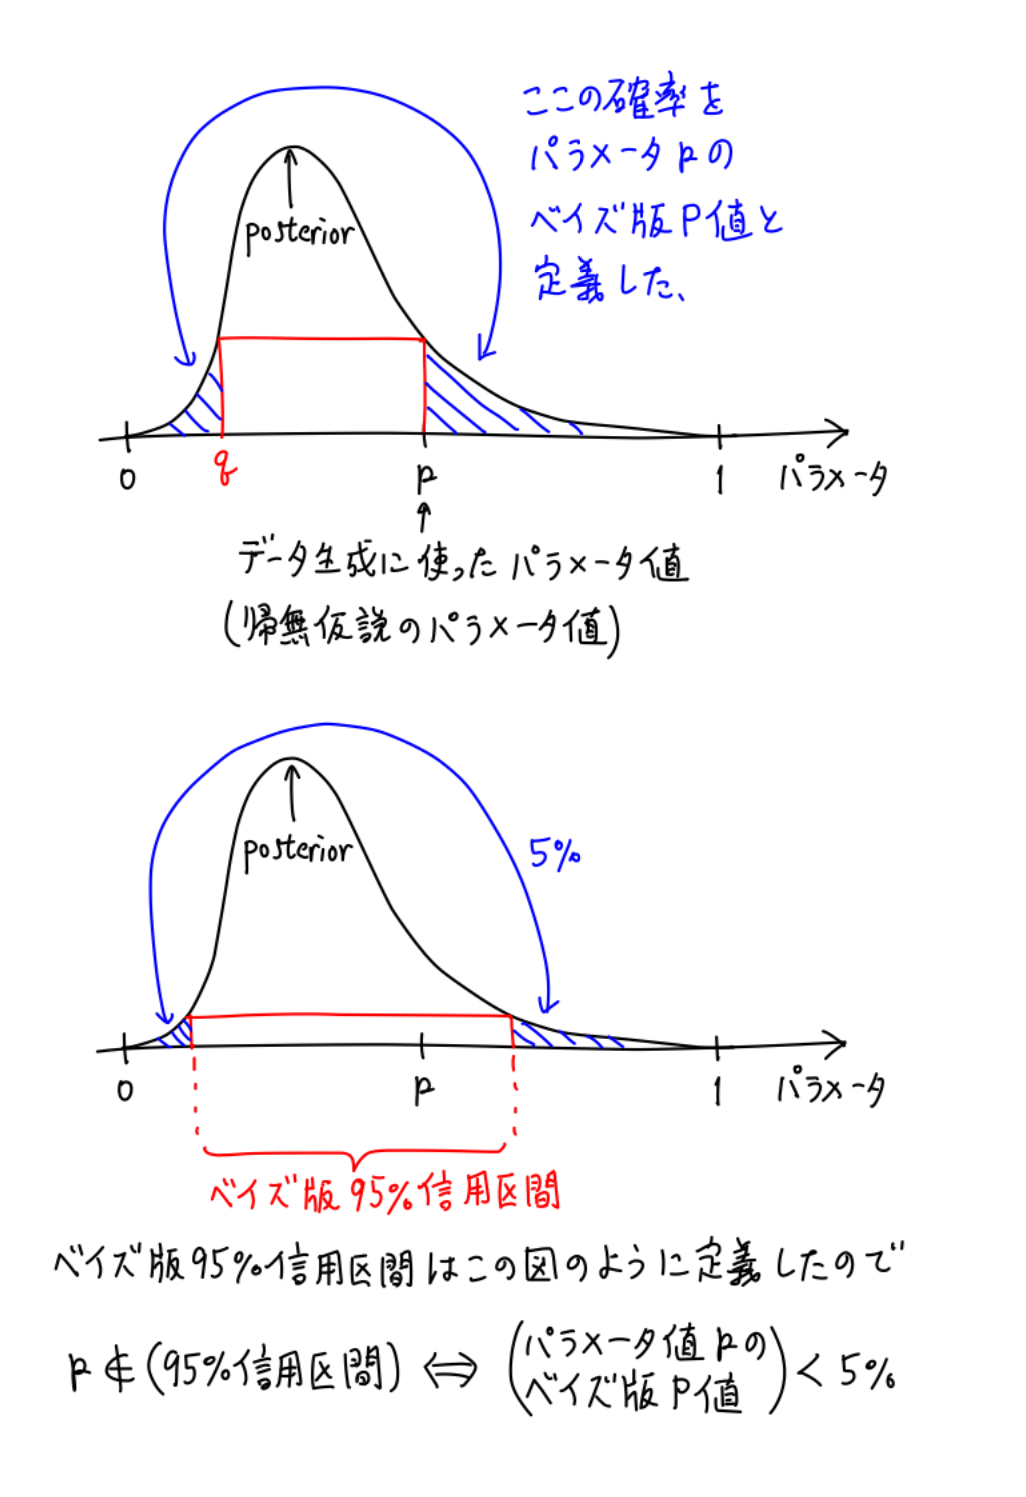

In [2]:
showimg("image/jpeg", "IMG_2864.jpg"; tag="img width=50%")


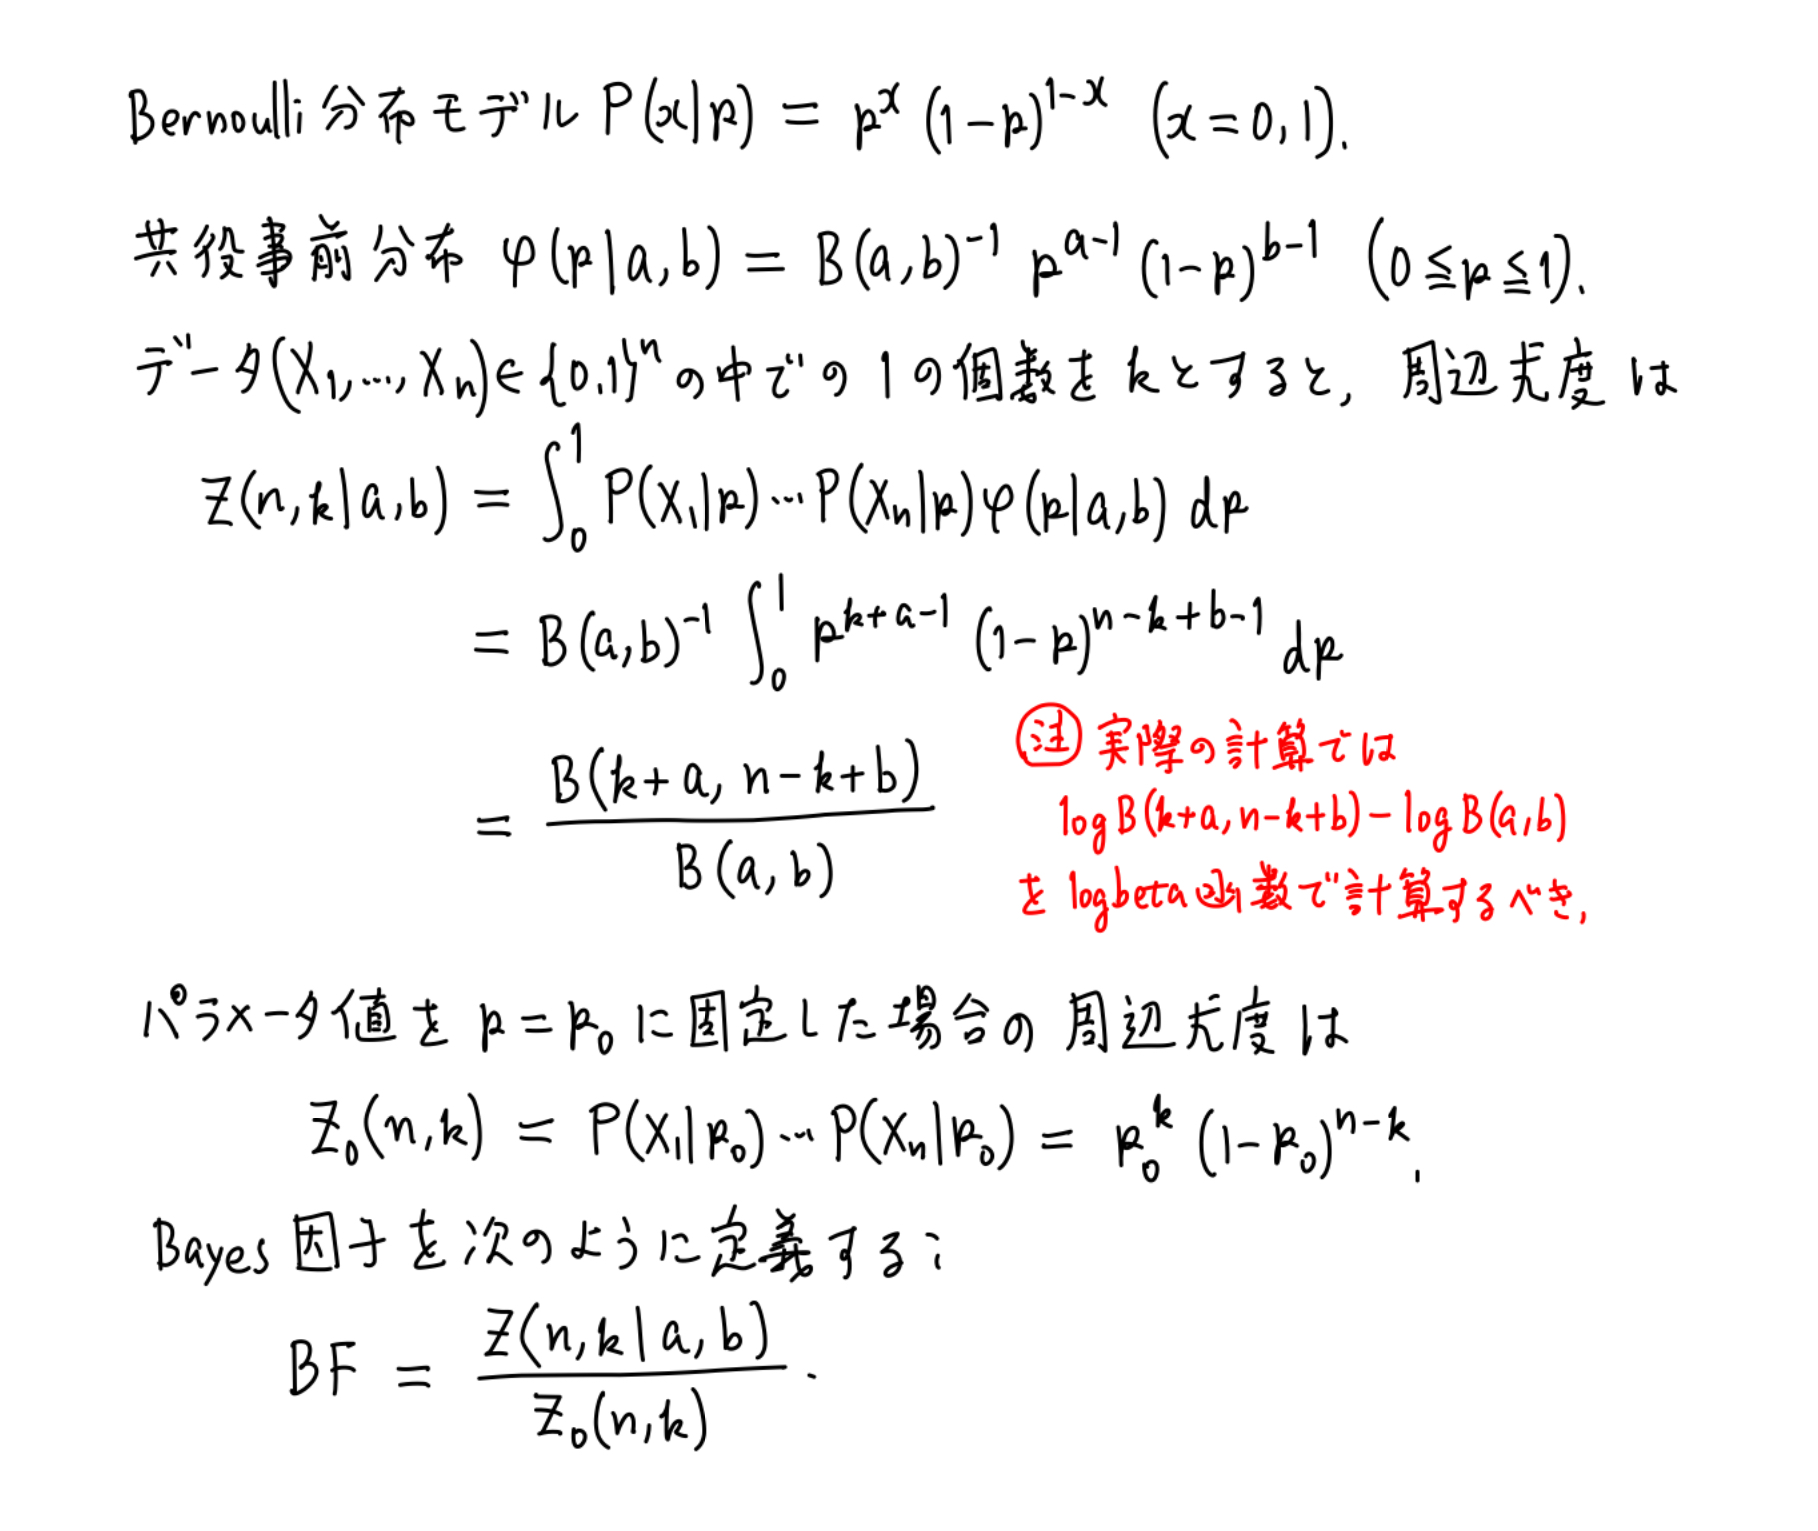

In [3]:
showimg("image/jpeg", "IMG_2865.jpg"; tag="img width=60%")

In [4]:
"""
事前分布 Beta(a, b) のもとでn回中ｋ回成功の場合の事後分布は Beta(k+a, n-k+b) になる。
デフォルトでは a = b = 1 の一様事前分布を採用することにする。
"""
posterior_dist(n, k; a=1, b=a) = Beta(k + a, n - k + b)

"""
pvalue_bayes(n, p, k; a, b) < α ⇔ p ∉ (ベイズ版100(1-α)%信用区間)
"""
@memoize function pvalue_bayes(n, p, k; a = 1, b = a)
    posterior = posterior_dist(n, k; a, b)
    v0 = logpdf(posterior, p)
    f(t) = logpdf(posterior, logistic(t)) - v0
    m = params(posterior) |> ((α, β),) -> (α - 1)/(α + β - 2)
    if m ≤ 0
        s = ccdf(posterior, p)
    elseif m ≥ 1
        s = cdf(posterior, p)
    elseif p ≤ m
        q = logistic(find_zero(f, min(50, logit(m) + 1)))
        s = cdf(posterior, p) + ccdf(posterior, q)
    else
        q = logistic(find_zero(f, max(-50, logit(m) - 1)))
        s = cdf(posterior, q) + ccdf(posterior, p)
    end
    min(1, s)
end

"""
Bernoulli(p)分布の独立試行をNまで行うとき、
pがベイズ版信用区間から外れるまでの試行回数をL個計算
"""
function bayeshacking(N, p; α = 0.05, L = 10^4, a = 1, b = a)
    numtrials = fill(N + 1, L)
    Threads.@threads for i in 1:L
        k = 0
        for n in 1:N
            k += rand(Bernoulli(p))
            if pvalue_bayes(n, p, k; a, b) < α
                numtrials[i] = n
                break
            end
        end
    end
    numtrials
end

bayeshacking

In [5]:
numtrials_bhack = bayeshacking(10^3, 0.5)
[(n, ecdf(numtrials_bhack)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.2184)
 (100, 0.4128)
 (1000, 0.5613)

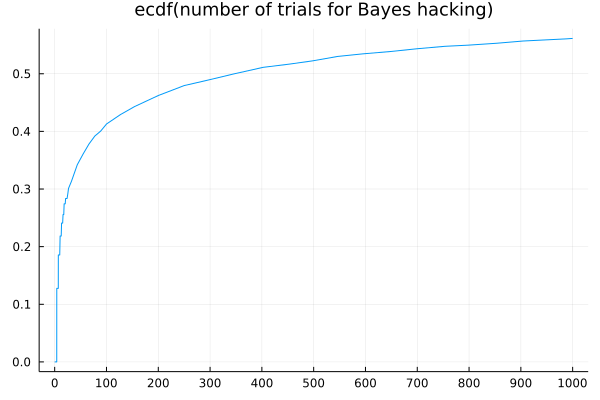

In [6]:
plot(n -> ecdf(numtrials_bhack)(n), 0, 10^3; label="", xtick=0:100:1000)
title!("ecdf(number of trials for Bayes hacking)"; titlefontsize=12)

In [7]:
"""通常のP値函数(exact版)"""
@memoize function pvalue_exact(n, p, k)
    bin = Binomial(n, p)
    p0 = pdf(bin, k)
    s = sum(pdf(bin, j) for j in support(bin) if pdf(bin, j) ⪅ p0)
    min(1, s)
end

"""通常のP値函数(正規分布近似)"""
@memoize function pvalue_normal(n, p, k)
    bin = Binomial(n, p)
    normal = Normal(mean(bin), std(bin))
    min(1, 2cdf(normal, k), 2ccdf(normal, k))
end

"""
Bernoulli(p)分布の独立試行をNまで行うとき、
P値がα未満になるまでの試行回数をL個計算
"""
function phacking(pvalue_func, N, p; α = 0.05, L = 10^4)
    numtrials = fill(N + 1, L)
    Threads.@threads for i in 1:L
        k = 0
        for n in 1:N
            k += rand(Bernoulli(p))
            if pvalue_func(n, p, k) < α
                numtrials[i] = n
                break
            end
        end
    end
    numtrials
end

phacking

In [8]:
numtrials_phack_exact = phacking(pvalue_exact, 10^3, 0.5)
[(n, ecdf(numtrials_phack_exact)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.0519)
 (100, 0.2257)
 (1000, 0.4075)

In [9]:
numtrials_phack_normal = phacking(pvalue_normal, 10^3, 0.5)
[(n, ecdf(numtrials_phack_normal)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.1582)
 (100, 0.3671)
 (1000, 0.5247)

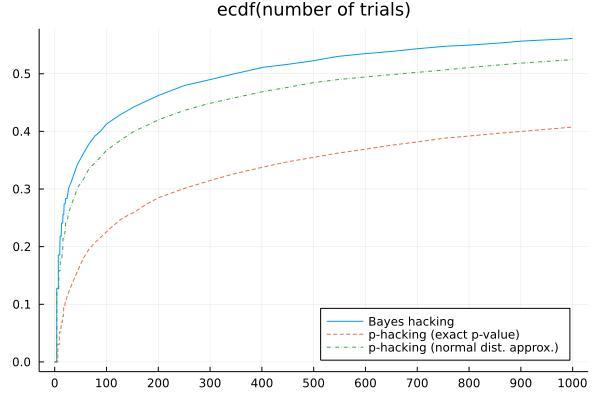

In [10]:
plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_bhack)(n), 0, 10^3; label="Bayes hacking", xtick=0:100:1000)
plot!(n -> ecdf(numtrials_phack_exact)(n), 0, 10^3; label="p-hacking (exact p-value)", xtick=0:100:1000, ls=:dash)
plot!(n -> ecdf(numtrials_phack_normal)(n), 0, 10^3; label="p-hacking (normal dist. approx.)", xtick=0:100:1000, ls=:dashdot)
title!("ecdf(number of trials)"; titlefontsize=12)

In [11]:
"""
対数周辺尤度比 (χ²分布のスケールに合わせるために2倍しておく)
Bayes因子 = exp(logmarginallikrat(n, p, k; a, b)/2)
"""
@memoize function logmarginallikrat(n, p, k; a=1, b=a)
    logmarginallik = 2(logbeta(k + a, n - k + b) - logbeta(a, b))
    logmarginallik0 = 2(safemul(k, log(p)) + safemul(n - k, log(1 - p)))
    logmarginallik - logmarginallik0
end

"""
Bayes因子ハッキングに挑戦
Bayes因子 > threshold となるまでデータを取得し続ける。
"""
function try_bfhacking(N, p; threshold=10, L=10^4, a=1, b=a)
    numtrials = fill(N + 1, L)
    Threads.@threads for i in 1:L
        k = 0
        for n in 1:N
            k += rand(Bernoulli(p))
            if logmarginallikrat(n, p, k; a, b) > 2log(threshold)
                numtrials[i] = n
                break
            end
        end
    end
    numtrials
end

"""
Bayes因子ハッキングに類似のpハッキングに挑戦
"""
function try_phacking_like_bfhacking(pvalue_func, N, p; threshold=10, L=10^4)
    numtrials = fill(N + 1, L)
    Threads.@threads for i in 1:L
        k = 0
        for n in 1:N
            k += rand(Bernoulli(p))
            α_n = ccdf(Chisq(1), 2log(threshold) + log(n))
            if pvalue_func(n, p, k) < α_n
                numtrials[i] = n
                break
            end
        end
    end
    numtrials
end

try_phacking_like_bfhacking

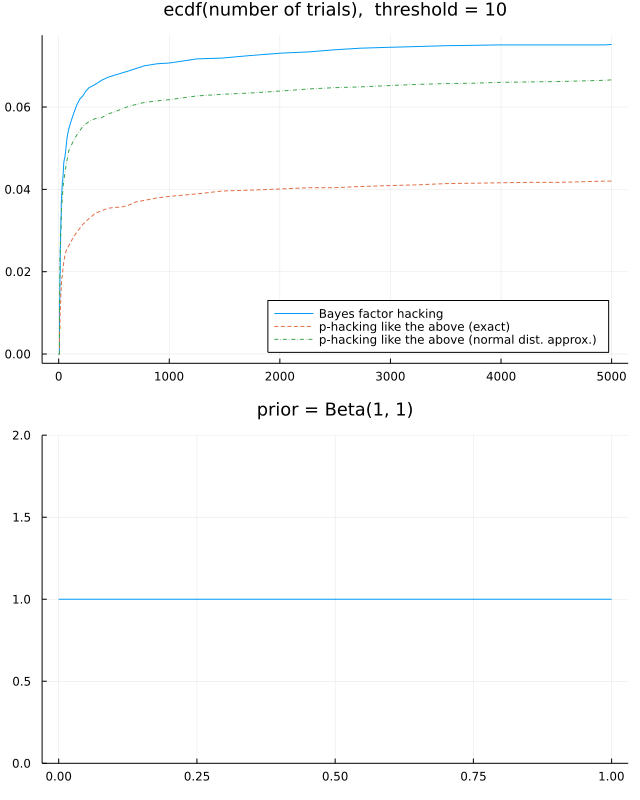

In [12]:
N, threshold = 5000, 10
a, b = 1, 1
numtrials_bfhack = try_bfhacking(N, 0.5; threshold, a, b)
numtrials_phack_like_bfhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold)
numtrials_phack_like_bfhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold)

P = plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_bfhack)(n), 0, N; label="Bayes factor hacking")
plot!(n -> ecdf(numtrials_phack_like_bfhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
plot!(n -> ecdf(numtrials_phack_like_bfhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)

Q = plot(Beta(a, b); ylim=(0, 2), label="")
title!("prior = Beta($a, $b)"; titlefontsize=12)

plot(P, Q; size=(640, 800), layout=(2, 1))

この場合には threshold = 5 のとき、Bayes因子 > 10 という条件でデータ取得を止めることに成功する確率は数パーセントのオーダーになっている。これの類似をP値を使ってやっても概ね結果は同じになる(有意水準を `α_n = ccdf(Chisq(1), 2log(threshold) + log(n))` によって n について単調減少するように決めている)。

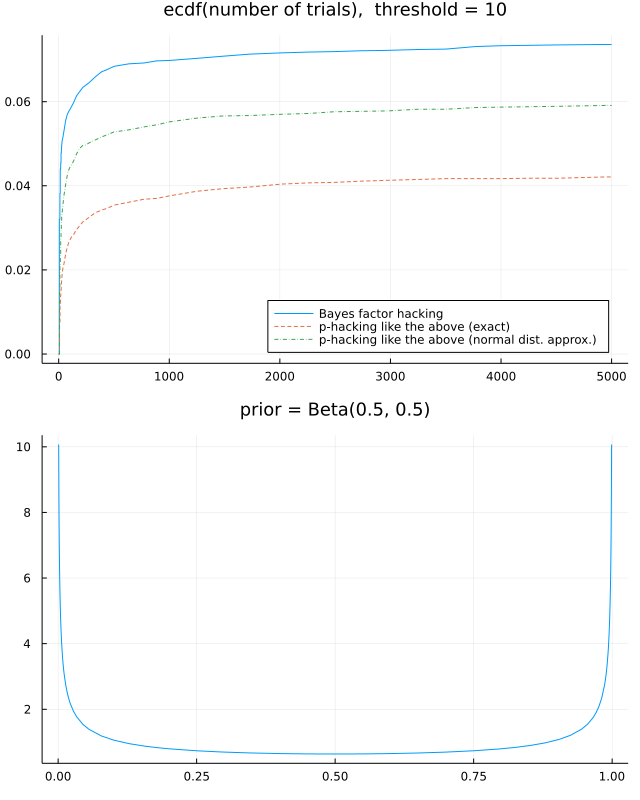

In [13]:
N, threshold = 5000, 10
a, b = 0.5, 0.5
numtrials_bfhack = try_bfhacking(N, 0.5; threshold, a, b)
numtrials_phack_like_bfhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold)
numtrials_phack_like_bfhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold)

P = plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_bfhack)(n), 0, N; label="Bayes factor hacking")
plot!(n -> ecdf(numtrials_phack_like_bfhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
plot!(n -> ecdf(numtrials_phack_like_bfhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)

Q = plot(Beta(a, b), 0.001, 0.999; label="")
title!("prior = Beta($a, $b)"; titlefontsize=12)

plot(P, Q; size=(640, 800), layout=(2, 1))

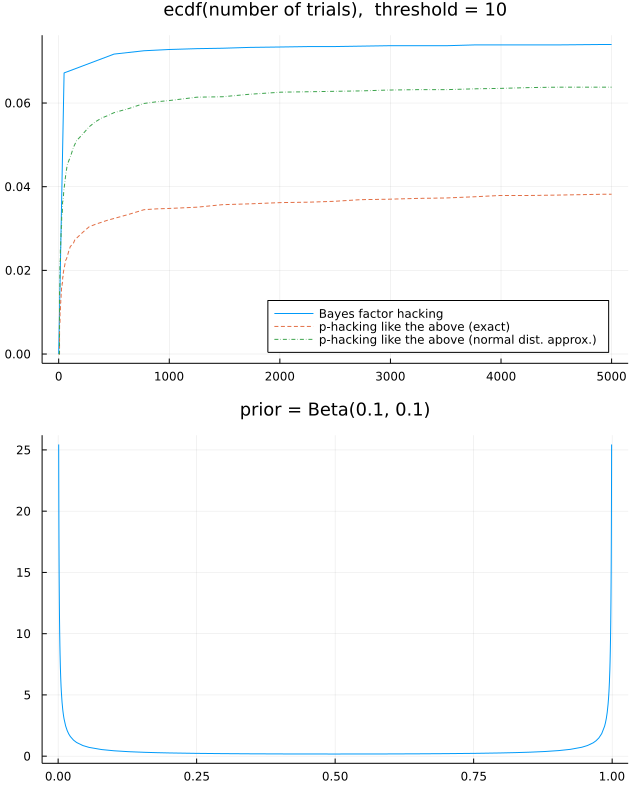

In [14]:
N, threshold = 5000, 10
a, b = 0.1, 0.1
numtrials_bfhack = try_bfhacking(N, 0.5; threshold, a, b)
numtrials_phack_like_bfhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold)
numtrials_phack_like_bfhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold)

P = plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_bfhack)(n), 0, N; label="Bayes factor hacking")
plot!(n -> ecdf(numtrials_phack_like_bfhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
plot!(n -> ecdf(numtrials_phack_like_bfhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)

Q = plot(Beta(a, b), 0.001, 0.999; label="")
title!("prior = Beta($a, $b)"; titlefontsize=12)

plot(P, Q; size=(640, 800), layout=(2, 1))

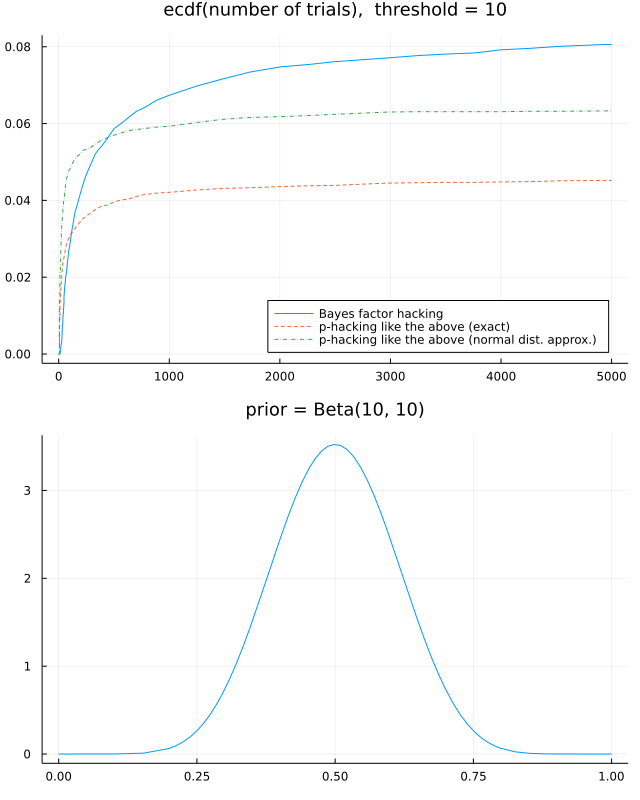

In [15]:
N, threshold = 5000, 10
a, b = 10, 10
numtrials_bfhack = try_bfhacking(N, 0.5; threshold, a, b)
numtrials_phack_like_bfhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold)
numtrials_phack_like_bfhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold)

P = plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_bfhack)(n), 0, N; label="Bayes factor hacking")
plot!(n -> ecdf(numtrials_phack_like_bfhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
plot!(n -> ecdf(numtrials_phack_like_bfhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)

Q = plot(Beta(a, b); label="")
title!("prior = Beta($a, $b)"; titlefontsize=12)

plot(P, Q; size=(640, 800), layout=(2, 1))

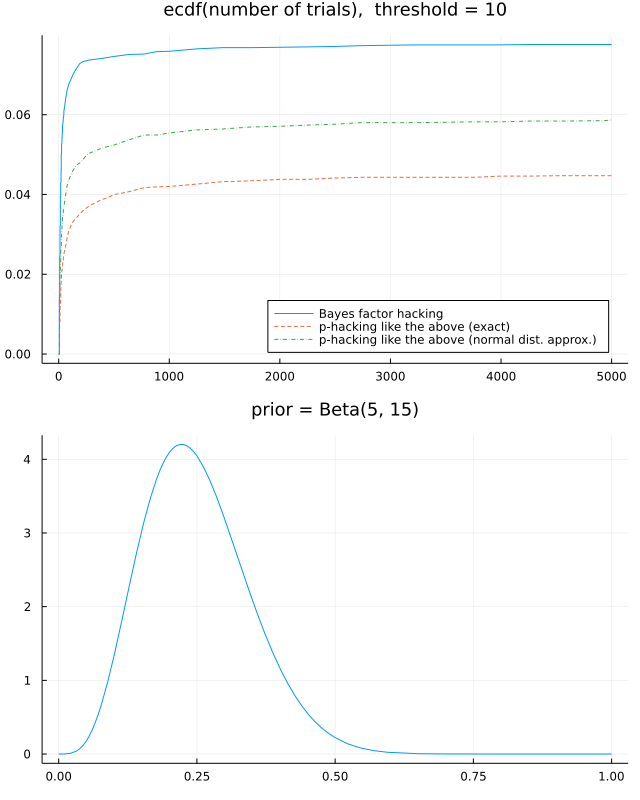

In [16]:
N, threshold = 5000, 10
a, b = 5, 15
numtrials_bfhack = try_bfhacking(N, 0.5; threshold, a, b)
numtrials_phack_like_bfhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold)
numtrials_phack_like_bfhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold)

P = plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_bfhack)(n), 0, N; label="Bayes factor hacking")
plot!(n -> ecdf(numtrials_phack_like_bfhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
plot!(n -> ecdf(numtrials_phack_like_bfhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)

Q = plot(Beta(a, b); label="")
title!("prior = Beta($a, $b)"; titlefontsize=12)

plot(P, Q; size=(640, 800), layout=(2, 1))

Stirlingの公式を使った計算によって, $k = np$ のとき, $n\to\infty$ で

$$
\begin{aligned}
\text{log(marginal likelihood ratio)} &=
\log B(k+a, n-k+b) - \log B(a, b)) - \log(p^k(1-p)^{n-p}
\\ &=
a\log p + b\log(1-p) - \frac{1}{2}\log\frac{np(1-p)}{2\pi} - \log B(a, b) + o(1)
\end{aligned}
$$

右辺は対数周辺尤度比の漸近挙動であり, $-(1/2)\log n + \mathrm{const.}$ の形をしている. 実際にはχ²分布のスケールに合わせるために２倍してあったことに注意せよ. そのおかげで, `k` が `Binomial(n, p)` 分布に従う確率変数のとき `logmarginallikrat(n, p, k; a, b)` はその最小値(上の２倍)と自由度１のχ²分布に従う確率変数の和に近似的に等しい.

In [17]:
function plot_ecdflmlr(n, p=0.5; L=10^4, a=1, b=a)
    k = rand(Binomial(n, p), L)
    lmlr = @. logmarginallikrat(n, p, k; a, b)
    @show lmlr_min = logmarginallikrat.(n, p, n*p; a, b)
    @show 2(a*log(p) + b*log(1-p) - 1/2*log(n*p*(1-p)/(2π)) - logbeta(a, b))
    @show -log(n)
    @show 2(a*log(p) + b*log(1-p) - 1/2*log(p*(1-p)/(2π)) - logbeta(a, b))
    lmlrmmin = lmlr .- lmlr_min
    plot(; legend=:bottomright)
    plot!(x -> ecdf(lmlrmmin)(x), 0, 8; label="ecdf(log marginal likelihood ratios - min)")
    plot!(x -> cdf(Chisq(1), x); label="cdf(Chisq(1), x)")
    title!("n = $n,  p = $p,  prior = Beta($a, $b)"; titlefontsize=12)
end

plot_ecdflmlr (generic function with 2 methods)

lmlr_min = logmarginallikrat.(n, p, n * p; a, b) = -1.9917051094206837
2 * (((a * log(p) + b * log(1 - p)) - (1 / 2) * log((n * p * (1 - p)) / (2π))) - logbeta(a, b)) = -1.851002387704591
-(log(n)) = -2.302585092994046
2 * (((a * log(p) + b * log(1 - p)) - (1 / 2) * log((p * (1 - p)) / (2π))) - logbeta(a, b)) = 0.451582705289455


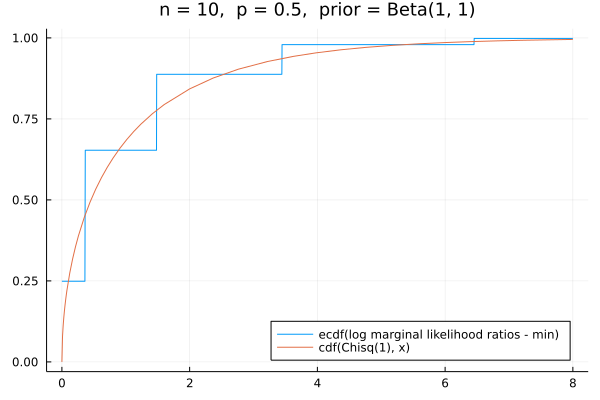

In [18]:
plot_ecdflmlr(10)

lmlr_min = logmarginallikrat.(n, p, n * p; a, b) = -4.168488225728282
2 * (((a * log(p) + b * log(1 - p)) - (1 / 2) * log((n * p * (1 - p)) / (2π))) - logbeta(a, b)) = -4.153587480698636
-(log(n)) = -4.605170185988092
2 * (((a * log(p) + b * log(1 - p)) - (1 / 2) * log((p * (1 - p)) / (2π))) - logbeta(a, b)) = 0.451582705289455


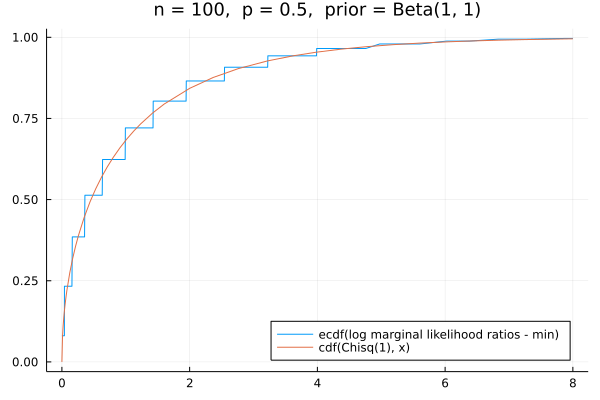

In [19]:
plot_ecdflmlr(100)

lmlr_min = logmarginallikrat.(n, p, n * p; a, b) = -6.457671574441747
2 * (((a * log(p) + b * log(1 - p)) - (1 / 2) * log((n * p * (1 - p)) / (2π))) - logbeta(a, b)) = -6.456172573692682
-(log(n)) = -6.907755278982137
2 * (((a * log(p) + b * log(1 - p)) - (1 / 2) * log((p * (1 - p)) / (2π))) - logbeta(a, b)) = 0.451582705289455


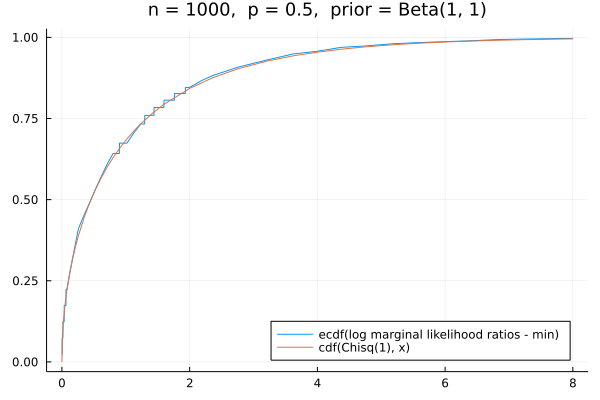

In [20]:
plot_ecdflmlr(1000)